## Reinforcement Learning project - July 2024
### Luca Bertone


In this notebook, the goal has been to implement a Reinforcement Learning algorithm to learn how to play Quentin, a board game.

The game consists of a $13x13$ grid, according to the rules of the game, and two players have to place some *stones* on the intersections of this grid, aiming at completing a way of orthogonally adjacent stones from one side of the grid to the other. Specifically, the **Black** player, has to complete a way such that it connects the top to the bottom of the grid, while the **White** has to complete a left-to-right way.

The implementation of the game (Quentin.py) and the detailed rules (Quentin.pdf) are attached to this notebook.

In [1]:
import random
import numpy as np
import torch
from collections import deque
import matplotlib.pyplot as plt

from Quentin import QuentinGame

In [2]:
# use GPU if available
device = torch.device(
    "cuda" if torch.cuda.is_available() else
    "mps" if torch.backends.mps.is_available() else
    "cpu"
)

In the context of Reinforcement Learning, one could try to describe this game in terms of MDP components, where:

• $S$ is the space of states: one state corresponds to a specific pattern of $\{-1,0,1\}$ values, where an empty intersection has a $-1$ value, and a filled intersection has a value in $\{0,1\}$, for the presence of a black stone or a white stone, respectively. <br>Given a $M\times M$-dimensional grid, one could assume that $|S|=3^{M\times M}$. Of course a lot of combinations should be discarded since they are not compliant with the game rules, but still the state space is huge.

• $A$ is the space of actions: in general, an upper bound for the number of actions available at any state is $|A|=M\times M$, but the number of actions decreases at any time step and, again, the rules are such that some actions might be discarded a priori for a certain state configuration.

• $R$ is the reward structure, for which there are not guidelines: it has to be established during the implementation of the RL algorithm.

• $p(s',r|s,a)$, the transition probabilities are not known. 

The main issue of this application is the dimensionality of the state space, which makes it not possible to treat the problem in a tabular form.<br>
For this reason, the approach which will be presented in what follows is **Deep Q-Learning** (DQN), a reinforcement learning algorithm that combines Q-learning with deep neural networks. Specifically, DQN employs a deep neural network to approximate the Q-function, allowing it to handle environments with large or continuous state spaces.<br>
The Q-function, also known as the action-value function, is a function that predicts the expected cumulative future rewards that an agent will receive, starting from a given state and taking a specific action: $Q(s,a)= \mathop{{}\mathbb{E}}[r_t + \gamma * max_{a'}Q(s_{t+1},a')|s_t=s, a_t=a]$. <br>
The network is trained to minimize the difference between its Q-value predictions and the actual rewards received.

![Local image](./Pseudo-code-of-deep-Q-learning-with-experience-replay.png)

The building blocks for this algorithm are:<br>
(a) a neural network architecture,<br>
(b) a memory object to store the past transitions: $(s_t,a_t,r_t,s_{t+1})$<br> 
(b) a mechanism for minibatch sampling from the transitions, needed during the training phase (by randomly sampling from the experiences, this breaks the bias that may have come from the sequential nature of a particular environment),<br>
(c) auxiliary functions to perform all the intermediate operations: store transitions into memory, take next action, update parameters, convert the state data in a suitable format to be the input of the neural network, rank the actions according to their values.<br><br>

Moreover, in many implementations two distinct neural networks are introduced. These networks have the same architecture but different weights. Every $N$ steps, the weights from the **main network** are copied to the **target network**. Using both of these networks leads to more stability in the learning process and helps the algorithm to learn more effectively. <br><br>
Most of this will be part of a newly defined class: the **Agent**. 

In [3]:
class DQN(torch.nn.Module):
    """
    Neural network class
    """
    def __init__(self, state_size, action_size, kernel_dim=128):
        super(DQN, self).__init__()
        self.layer1 = torch.nn.Linear(state_size, kernel_dim)
        self.layer2 = torch.nn.Linear(kernel_dim, kernel_dim)
        self.layer3 = torch.nn.Linear(kernel_dim, action_size)        
        self._initialize_weights()      # Apply He initialization to the layers

    def _initialize_weights(self):
        """
        Kaiming initialization: a good initialization strategy for NN with Relu activations
        (https://towardsdatascience.com/all-ways-to-initialize-your-neural-network-16a585574b52)
        """
        for m in self.modules():
            if isinstance(m, torch.nn.Linear):
                torch.nn.init.kaiming_normal_(m.weight, mode='fan_in', nonlinearity='relu')
                if m.bias is not None:
                    torch.nn.init.constant_(m.bias, 0)

    def forward(self, x):
        x = torch.nn.functional.relu(self.layer1(x))
        x = torch.nn.functional.relu(self.layer2(x))
        return self.layer3(x)

In [40]:
##ChatGPT contribution to define the general structure of the class and the functions to be implemented##

class QuentinDQNAgent:
    """
    Agent class
    """
    def __init__(self, size, state_size, action_size, **kwargs):
        self.size = size
        self.state_size = state_size
        self.action_size = action_size
        self.memory = deque(maxlen=20000)
        ## Parameters
        self.gamma = kwargs.get('gamma', 0.95)
        self.epsilon = kwargs.get('epsilon', 1.0)
        self.epsilon_max = kwargs.get('epsilon_max', 1.0)
        self.epsilon_min = kwargs.get('epsilon_min', 0.01)
        self.epsilon_decay = kwargs.get('epsilon_decay', 0.9)
        self.learning_rate = kwargs.get('learning_rate', 0.01)
        self.tau = kwargs.get('tau', 0.01)
        ## Neural networks: Policy network and Target network
        self.model = DQN(state_size, action_size, kernel_dim=kwargs.get('kernel_size', 128)).to(device)
        self.target_model = DQN(state_size, action_size, kernel_dim=kwargs.get('kernel_size', 128)).to(device)
        self.optimizer = torch.optim.Adam(self.model.parameters(), lr=self.learning_rate)
        self.scheduler = torch.optim.lr_scheduler.StepLR(self.optimizer, step_size=1000, gamma=0.95)
        ## Loss function: 
        #  The Huber loss acts like the mean squared error when the error is small, but like the mean absolute error when
        #  the error is large - this makes it more robust to outliers when the estimates of 𝑄 are very noisy
        #  (https://pytorch.org/tutorials/intermediate/reinforcement_q_learning.html)
        self.criterion = torch.nn.SmoothL1Loss()
        # self.criterion = torch.nn.functional.MSELoss()

    def update_target_model(self):
        """
        define how to update the Target network's weights
        """
        # "Hard" update "once in a while"
        # self.target_model.load_state_dict(self.model.state_dict())
        
        ## Soft update controlled by the hyperparameter TAU: the target network is updated at every step 
        target_model_state_dict = self.target_model.state_dict()
        model_state_dict = self.model.state_dict()
        for key in model_state_dict:
            target_model_state_dict[key] = model_state_dict[key]*self.tau + target_model_state_dict[key]*(1-self.tau)
        self.target_model.load_state_dict(target_model_state_dict)


    def remember(self, state, action, reward, next_state, done):
        """
        add information from each step to the memory of the model: 
        this information will be crucial for the "replay" step, since the 
        minibatches come from here
        """
        self.memory.append((state, action, reward, next_state, done))


    def act(self, state, unavail):
        """
        the agent selects an action based on the current state or at random
        """
        available_actions = list(set(range(self.action_size)) - set(unavail))
        if not available_actions:
            return None
        ## if the random value is smaller than epsilon, extract a random action
        if np.random.rand() <= self.epsilon:
            return random.choice(available_actions)
        #  otherwise, extract the action with the best value estimate
        act_values = self.model(torch.FloatTensor(state))
        available_q_values = act_values[available_actions]
        return available_actions[torch.argmax(available_q_values).item()]


    def epsilon_update(self, episode):
        if self.epsilon > self.epsilon_min:
            return self.epsilon_min + (self.epsilon_max - self.epsilon_min) * np.exp(-self.epsilon_decay * episode)
        else:
            return self.epsilon


    def replay(self, batch_size, losses=[]):
        """
        the core of the learning procedure: optimization of the weights of the Policy network, based on the 
        loss, which is calculated for the tuples in the minibatch (a random sample of the memory of the model)
        """
        minibatch = random.sample(self.memory, batch_size)
        for state, action, reward, next_state, done in minibatch:
            # TD target (Q-Target) using Target network
            target = reward
            if not done:
                target += self.gamma * torch.max(self.target_model(torch.FloatTensor(next_state))).item()
            # Former Q-value estimation (using Policy network)
            target_f = self.model(torch.FloatTensor(state))
            target_f[action] = target
            # Loss value and optimization step
            self.optimizer.zero_grad()
            loss = self.criterion(target_f, self.model(torch.FloatTensor(state)))
            losses.append(loss)
            loss.backward()
            self.optimizer.step()
            self.scheduler.step()
        # if self.epsilon > self.epsilon_min:
        #     self.epsilon *= self.epsilon_decay


    def save(self, name):
        torch.save(self.model.state_dict(), name)


def load_model(model_path, state_size, action_size, kernel_size=128):
    model = DQN(state_size, action_size, kernel_size)
    model.load_state_dict(torch.load(model_path))
    model.eval()  # Set the model to evaluation mode
    return model


def convert_state(board, size, player):
    """
    convert the relevant information for the state of the agent (the board matrix & the binary for the player) 
    into an array of length: size*size + 1
    """
    state = np.zeros((size * size + 1))
    for i, val in enumerate(board):
        state[i] = val
    state[-1] = player
    return state


def rank_actions(model, state):
    """
    when applied to a certain input (environment state), the network gives as output the q-values 
    associated to the various actions, in the original order used for the training.
    this utility function ranks the actions based on their q-value in decreasing order. 
    """
    state_tensor = torch.FloatTensor(state).unsqueeze(0)  # Add batch dimension
    with torch.no_grad():
        q_values = model(state_tensor).numpy().flatten()
    ranked_actions = np.argsort(q_values)[::-1]  # Sort actions by Q-value in descending order
    q_values = q_values[ranked_actions]
    return ranked_actions, q_values

There are several options for training a RL agent in the context of competitive games.<br>
For example, one could try to train the two agents simultaneously, so that each agent continuously adapts to the strategies of the other. <br>
In what follows, an implementation of such a strategy is presented.

In [12]:
def simultaneous_rewards(gameover):
    """
    the rewards structure of this problem:
    • an agent receives no reward if, after their action, the opponent took a move which didn't make the game finish,
    • an agent receives a very negative reward (-100) and a very positive reward (+100) if he loses or he wins the game, respectively.
    """
    if gameover == -1:
        black_reward = 0
        white_reward = 0
        done = False
    elif gameover == 0:
        black_reward = 100 
        white_reward = -100
        done = True
    else:
        black_reward = -100 
        white_reward = 100
        done = True    
    return black_reward, white_reward, done


def simultaneous_learning(size=7, episodes=20, batch_size=128, epsilon_decay=0.95, learning_rate=0.01, save_episodes=None):
    """
    run the algorithm:
    first, initialize the environment and some important variables; 
    then, start to alternatively pick an action with the black and with the white player;
    each of them uses the opponent's move to evaluate their own actions.
    
    Hyperparameters:
    self.gamma = kwargs.get('gamma', 0.95)
    self.epsilon = kwargs.get('epsilon', 1.0)
    self.epsilon_max = kwargs.get('epsilon_max', 1.0)
    self.epsilon_min = kwargs.get('epsilon_min', 0.01)
    self.epsilon_decay = kwargs.get('epsilon_decay', 0.9)
    self.learning_rate = kwargs.get('learning_rate', 0.01)
    self.tau = kwargs.get('tau', 0.01)
    """
    state_size = size * size + 1    # size*size is the dimension of the board, the additional unit denotes the player
    action_size = size * size    #potentially, the available actions are represented by the board 
    
    # Initialize two agents which will learn by playing against each other
    black_agent = QuentinDQNAgent(size, state_size, action_size, kernel_size=128)
    white_agent = QuentinDQNAgent(size, state_size, action_size, kernel_size=128)

    steps = 0
    losses_black = []
    losses_white = []

    for e in (range(episodes+1)):
        # Start a new game
        # print("Episode: " + str(e))
        game = QuentinGame(size)
        done = False
        first_action = True
        not_available_actions_black = []      
        not_available_actions_white = []     # it holds the indexes of the actions which cannot be picked by the player in a certain state;
                                            # after the player tries to take a "forbidden" action, it is inserted here 
                                            # and the player has to choose another action from a subset of the original action space 
        
        while not done:            
            ## BLACK's turn
            black_state = convert_state(game.board, size, 0)
            black_action = black_agent.act(black_state, [])
            
            # if the black's move is illegal, look for another action
            while black_action is not None and not game.update_board(True, black_action, not_available_actions_black):
                black_reward = -1
                # store in memory the "transition" (although no transition actually happened):
                black_next_state = convert_state(game.board, size, 0)
                black_agent.remember(black_state, black_action, black_reward, black_next_state, done)
                black_state = black_next_state
                # look for a new action:
                black_action = black_agent.act(black_state, not_available_actions_black)    

                # if no moves are available for the black, it's a Draw
                # assign rewards: for example, a negative one for the black (being the first to play, should try to win), and zero for the white 
                if black_action is None:
                    black_reward = -10
                    white_reward = 0
                    done = True
                    break
            #  and start a new episode
            if done:
              break

            # if the black player picked an action, assign rewards to both players
            if black_action is not None:           
                black_reward, white_reward, done = simultaneous_rewards(game.gameover())

            ###the white agent waits until the black does a new move to store info on the next state
            ###this condition prevents from storing a "new" state for the white agent after the very first move of the black
            if first_action is not True:
                if white_action is not None:
                    white_next_state = convert_state(game.board, size, 1)
                    white_agent.remember(white_state, white_action, white_reward, white_next_state, done)
            else:
                first_action = False

            ## WHITE's turn
            if not done:
                white_state = convert_state(game.board, size, 1)
                white_action = white_agent.act(white_state, [])                
                # if the white's move is illegal, look for another action
                while white_action is not None and not game.update_board(False, white_action, not_available_actions_white):
                    white_reward = -1
                    white_next_state = convert_state(game.board, size, 1)
                    white_agent.remember(white_state, white_action, white_reward, white_next_state, done)
                    white_state = white_next_state
                    white_action = white_agent.act(white_state, not_available_actions_white)
                    

                    # if no moves are available for the white, it's a Draw
                    # assign rewards: for example, a negative one for the black (being the first to play, should try to win), and zero for the white 
                    if white_action is None:
                        black_reward = -10
                        white_reward = 0
                        done = True
                        break
                #  and start a new episode
                if done:
                    break
              
                # if the white player picked an action, assign rewards to both players
                if white_action is not None:
                      black_reward, white_reward, done = simultaneous_rewards(game.gameover())

            # the black agent waits until the white does a new move to store info on the next state
            if black_action is not None:
                black_next_state = convert_state(game.board, size, 0)
                black_agent.remember(black_state, black_action, black_reward, black_next_state, done)

            # store next state for the white agent, in the event it wins over the black agent
            # without this (duplicated) code the white would not be able to save info after a victory (done==True, out of the while loop)  
            if done:
                white_next_state = convert_state(game.board, size, 1)
                white_agent.remember(white_state, white_action, white_reward, white_next_state, done)
            
            # Training phase (minibatch sampling and policy parameters optimization)
            steps = steps + 1
            if steps % 4 == 0:
                if len(black_agent.memory) > batch_size and len(white_agent.memory) > batch_size:
                  black_agent.epsilon = black_agent.epsilon_update(e)
                  white_agent.epsilon = white_agent.epsilon_update(e)
                  black_agent.replay(batch_size, losses_black)
                  white_agent.replay(batch_size, losses_white)

            # Target network update
            if steps % 100 == 0:
                black_agent.update_target_model()
                white_agent.update_target_model()
        
        if e in save_episodes:
            black_agent.save(f"quentin_sz{size}_ep{e}__black")
            white_agent.save(f"quentin_sz{size}_ep{e}__white")

    return losses_black, losses_white

An alternative approach is to **alternate training sessions** where one agent learns while the other remains fixed. Again, the implementation is below. 

In [22]:
def alternate_rewards(gameover, is_black):
    """
    the rewards structure of this problem:
    • an agent receives no reward if, after their action, the opponent took a move which didn't make the game finish,
    • an agent receives a very negative reward (-100) and a very positive reward (+100) if he loses or he wins the game, respectively.
    """
    if gameover == -1:
        reward = 0
        done = False
    elif gameover == 0:
        reward = 100 if is_black else -100
        done = True
    else:
        reward = -100 if is_black else 100
        done = True    
    return reward, done


def next_move(board, size, agent, is_black, illegal):        
    """
    Auxiliary function for the selection of the optimal action, given a fixed policy
    """
    filled_locations = [i for i, x in enumerate(board) if x != -1]
    valid_move = False
    tmp = None

    state = convert_state(board, size, not is_black)
    ranked_actions, q_values = rank_actions(agent, state)
    i = 0
    while not valid_move and i < len(ranked_actions):
        next_best = ranked_actions[i]
        valid_move = next_best not in list(set(filled_locations) | set(illegal)) and 0 <= next_best < len(board)
        if valid_move:
            return next_best
        i += 1
    return None

In [39]:
def alternate_learning(learner_is_white, agent_name, size=7, episodes=20, batch_size=128, save_episodes=None):

    if learner_is_white:
        return white_learning(agent_name, size, episodes, batch_size, save_episodes)
    else:
        return black_learning(agent_name, size, episodes, batch_size, save_episodes)

In [37]:
def white_learning(agent_name, size, episodes, batch_size, epsilon_decay, learning_rate, tau, save_episodes):

    state_size = size * size + 1    # size*size is the dimension of the board, the additional unit denotes the player
    action_size = size * size    #potentially, the available actions are represented by the board
    losses = []

    agent_black = load_model(agent_name, state_size, action_size)
    agent_white = QuentinDQNAgent(size, state_size, action_size)

    steps = 0

    for e in range(episodes + 1):
        # print("Episode " + str(e))
        game = QuentinGame(size)
        done = False
        first_action = True
        not_available_actions_black = [] 
        not_available_actions_white = []      

        while not done:            
            steps = steps + 1
            ## BLACK's turn (optimal action according to the policy of agent_white)
            black_action = next_move(game.board, size, agent_black, True, not_available_actions_black)
            while black_action is not None and not game.update_board(True, black_action, not_available_actions_black):
                black_action = next_move(game.board, size, agent_black, True, not_available_actions_black)

            if black_action is None:
                white_reward = 0
                done = True
                break
            else:
                white_reward, done = alternate_rewards(game.gameover(), False)

            if not first_action:
                if white_action is not None:
                    white_next_state = convert_state(game.board, size, 1)
                    agent_white.remember(white_state, white_action, white_reward, white_next_state, done)
            else:
                first_action = False

            if done:
                white_next_state = convert_state(game.board, size, 1)
                agent_white.remember(white_state, white_action, white_reward, white_next_state, done)
                break

            ## WHITE's turn
            white_state = convert_state(game.board, size, 1)
            white_action = agent_white.act(white_state, not_available_actions_white)
            while white_action is not None and not game.update_board(False, white_action, not_available_actions_white):
                white_reward = -1
                white_next_state = convert_state(game.board, size, 1)
                agent_white.remember(white_state, white_action, white_reward, white_next_state, done)
                white_state = white_next_state
                white_action = agent_white.act(white_state, not_available_actions_white)

            if white_action is None:
                white_reward = 0
                done = True
                break
                
            if done:
                white_next_state = convert_state(game.board, size, 1)
                agent_white.remember(white_state, white_action, white_reward, white_next_state, done)
                break

            if steps % 15 == 0:
                if len(agent_white.memory) > batch_size:
                    agent_white.epsilon = agent_white.epsilon_update(e)
                    agent_white.replay(batch_size, losses)

            # if steps % 100 == 0:
            agent_white.update_target_model()
        
        if e in save_episodes:
            agent_black.save(f"quentin_sz{size}_ep{e}__white_alternating")
    
    return losses

In [38]:
def black_learning(agent_name, size, episodes, batch_size, save_episodes):

    state_size = size * size + 1    # size*size is the dimension of the board, the additional unit denotes the player
    action_size = size * size    #potentially, the available actions are represented by the board
    losses = []

    agent_black = QuentinDQNAgent(size, state_size, action_size)
    agent_white = load_model(agent_name, state_size, action_size)

    steps = 0

    for e in range(episodes + 1):
        # print("Episode " + str(e))
        game = QuentinGame(size)
        done = False
        first_action = True
        not_available_actions_black = [] 
        not_available_actions_white = []      

        while not done:            
            steps = steps + 1
            ## BLACK's turn
            black_state = convert_state(game.board, size, 0)
            black_action = agent_black.act(black_state, not_available_actions_black)
            
            while black_action is not None and not game.update_board(True, black_action, not_available_actions_black):
                black_reward = -1
                black_next_state = convert_state(game.board, size, 0)
                agent_black.remember(black_state, black_action, black_reward, black_next_state, done)
                black_state = black_next_state
                black_action = agent_black.act(black_state, not_available_actions_black)

            if black_action is None:
                black_reward = 0
                done = True
                break
            
            ## WHITE's turn (optimal action according to the policy of agent_white)
            white_action = next_move(game.board, size, agent_white, False, not_available_actions_white)
            while white_action is not None and not game.update_board(False, white_action, not_available_actions_white):
                white_action = next_move(game.board, size, agent_white, False, not_available_actions_white)

            if white_action is None:
                black_reward = 0
                done = True
                break
            else:
                black_reward, done = alternate_rewards(game.gameover(), True)

            if done:
                black_next_state = convert_state(game.board, size, 0)
                agent_black.remember(black_state, black_action, black_reward, black_next_state, done)
                break

            if steps % 15 == 0:
                if len(agent_black.memory) > batch_size:
                    agent_black.epsilon = agent_black.epsilon_update(e)
                    agent_black.replay(batch_size, losses)

            agent_black.update_target_model()
        
        if e in save_episodes:
                agent_black.save(f"quentin_sz{size}_ep{e}__black_alternating")
    
    return losses

As an example, let's try to use a **hybrid approach**, starting with simultaneuous learning so as to have a baseline policy for each player, then employing alternate learning for one agent at a time, with the other keeping its policy unchanged:

In [16]:
L_x_simult, L_y_simult = simultaneous_learning(size=7, episodes=25, batch_size=30, epsilon_decay=0.95, learning_rate=0.02, save_episodes=[25])

Now, we can keep one of the two policies fixed and try to improve the other one:

In [41]:
white_agent = "quentin_sz7_ep25__white"
losses_black = alternate_learning(False, white_agent, size=7, episodes=25, batch_size=30, save_episodes=[25])

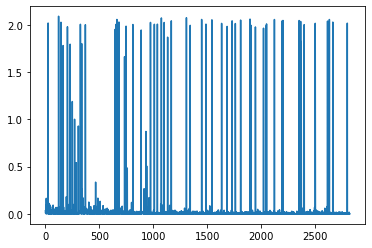

In [17]:
losses_black_simult = [tensor.item() for tensor in losses_black_simult]
plt.plot(losses_black_simult)

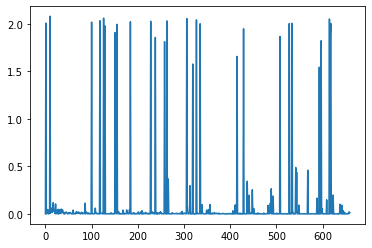

In [42]:
losses_black = [tensor.item() for tensor in losses_black]
plt.plot(losses_black)

Sources:<br>
https://towardsdatascience.com/deep-q-learning-tutorial-mindqn-2a4c855abffc<br>
https://towardsdatascience.com/all-ways-to-initialize-your-neural-network-16a585574b52<br>
https://pytorch.org/tutorials/intermediate/reinforcement_q_learning.html<br>
https://huggingface.co/learn/deep-rl-course/unit3/deep-q-algorithm<br>